# MHW Calculation and Satellite Climatology

This notebook computes the MHW event statistics as a Python dictionary. It also generates a netcdf of the climtology and threshold values for each of the pixels in the CBay.

In [1]:
import os
import pickle
from datetime import datetime, date

import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

In [2]:
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')

In [3]:
# dask.config.set({'temporary_directory':'/Users/rwegener/repos/ch'})

client = Client()

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51860,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:51873,Total threads: 2
Dashboard: http://127.0.0.1:51877/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:51865,


In [13]:
sst_filename = 'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
path = os.path.join(REPO_ROOT, 'data/raw', sst_filename)
geopolar = xr.open_dataset(path)
geopolar = geopolar.analysed_sst

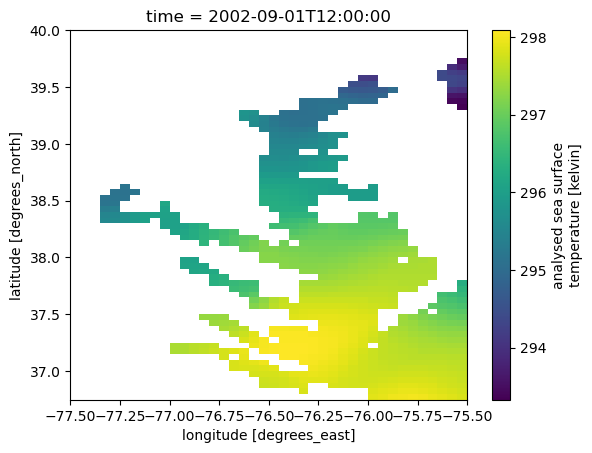

In [14]:
geopolar.isel(time=0).plot()

## Calculate Marine Heatwaves using `marineHeatWaves` Package

### Preprocessing

In [15]:
def format_time(time_np):
    # Format time values
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') 
                    for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list])

In [16]:
time_ordinal = format_time(geopolar.time.values)
sst_np = geopolar.values

**Nice-to-have** this really shouldn't have to run twice.

### Run the `mhw.detect()` function - Geopolar

In [17]:
%%time

sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

# define a wrapper to rearrange arguments
def func1d(arr, time):
    return mhw.detect(time, arr)

def block_func(block, **kwargs):
    return np.apply_along_axis(func1d, 0, block, **kwargs)

result = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
result = result.compute()

/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/marineHeatWaves/marineHeatWaves.py:283: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/marineHeatWaves/marineHeatWaves.py:283: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/marineHeatWaves/marineHeatWaves.py:283: RuntimeWarning: Mean of empty slice
  seas_

CPU times: user 10.1 s, sys: 2.75 s, total: 12.9 s
Wall time: 3min 5s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [20]:
event_statistics = result[0]

### Save the event statistics as a byte stream (pickle) for later processing

In [24]:
path = os.path.join(REPO_ROOT, 'data/interim', 'mhw_eventstats_dict.pickle')
with open(path, 'wb') as handle:
    pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Back to regular processing

_Alternate way to improve this workflow: The above computation runs once and gets all the information out of the `mhw.detect()` computation. A second one goes through and does the reformatting for the climatology and threshold._

I think I maybe have to do a loop? `np.vectorize` takes a scalar value but doesn't seem to be able to handle a 2D output, and `np.apply_along_axis` seems to be the opposite.

Progress:
```
def get_climatology(arr):
    return arr['seas']

output = np.vectorize(get_climatology)(result[1])
# or
np.apply_along_axis(get_climatology, 0, result[1])
```

In [25]:
climatology = np.empty(sst_np.shape)
threshold = np.empty(sst_np.shape)

In [26]:
for i in range(result[1].shape[0]):
    for j in range(result[1].shape[1]):
        climatology[:, i, j] = result[1, i, j]['seas']
        threshold[:, i, j] = result[1, i, j]['thresh']

The climatology is repeated for each of the years

### Save Climatology and Threshold

In [37]:
output_dir = os.path.join(REPO_ROOT, 'data/interim')

In [38]:
# create xarray objects from numpy output of mhw
clim = xr.DataArray(climatology, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using Eric Oliver marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [39]:
clim.to_dataset().to_netcdf(os.path.join(output_dir, 'geopolar_climatology_chesapeake.nc'))

In [40]:
# create xarray objects from numpy output of mhw
thresh = xr.DataArray(threshold, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
thresh = thresh.rename('threshold')

# add array attributes
thresh.attrs['comment'] = '90th percentile treshold values computed using Eric Oliver ' \
    'marineHeatWave package. Uses all defaults from .detect() function - 5 day window' \
    ' half width, 31 day smoothing'
thresh.attrs['source_dataset'] = 'NOAA Geopolar'
thresh.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

# save
thresh.to_dataset().to_netcdf(os.path.join(output_dir, 'geopolar_threshold_chesapeake.nc'))

## MUR

In [18]:
path = os.path.join(
    REPO_ROOT, 'data/raw', 
    'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-20020901_20230831.nc'
)
mur = xr.open_dataset(path).analysed_sst

In [19]:
mur

<xarray.DataArray 'analysed_sst' (time: 7667, lat: 326, lon: 201)>
[502387842 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01T09:00:00 ... 2023-08-31T09:00:00
  * lat      (lat) float32 36.75 36.76 36.77 36.78 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -77.5 -77.49 -77.48 -77.47 ... -75.52 -75.51 -75.5
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

In [20]:
time_ordinal = format_time(mur.time.values)
sst_np = mur.values

Oh my gosh this took 1 hour and 7 minutes to run for MUR. Good grief.

I guess it is about a linear scale from the Geopolar. 3min for geopolar * 25 times as many grid cells.

In [21]:
%%time

sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

# define a wrapper to rearrange arguments
def func1d(arr, time):
    return mhw.detect(time, arr)

def block_func(block, **kwargs):
    return np.apply_along_axis(func1d, 0, block, **kwargs)

result = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
result = result.compute()

CPU times: user 9min 1s, sys: 2min 19s, total: 11min 20s
Wall time: 1h 7min 6s


In [22]:
climatology = np.empty(sst_np.shape)

In [23]:
for i in range(result[1].shape[0]):
    for j in range(result[1].shape[1]):
        climatology[:, i, j] = result[1, i, j]['seas']

In [24]:
# create xarray objects from numpy output of mhw
clim = xr.DataArray(climatology, coords = mur.coords, dims=mur.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using Eric Oliver marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NASA MUR'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [25]:
path = os.path.join(REPO_ROOT, 'data/interim', 'mur_climatology_chesapeake.nc')
clim.to_dataset().to_netcdf(path)

In [28]:
clim

<xarray.DataArray 'climatology' (time: 7667, lat: 326, lon: 201)>
array([[[         nan,          nan,          nan, ..., 298.28976736,
         298.28607375, 298.28194108],
        [         nan,          nan,          nan, ..., 298.28406254,
         298.28034629, 298.27611123],
        [         nan,          nan,          nan, ..., 298.27693029,
         298.2733932 , 298.26943871],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ..., 298.21779313,
         298.21350393, 298.20882096],
        [         nan,          nan,          nan, ..., 298.21240333,
         298.20807082, 298.20328546],
        [         nan,          nan,          nan, ..., 298.2055477 ,
         298.20137368, 298.19683149],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ..., 298.35886408,
         298.35575817, 298.35216793],
        [         nan,          nan,          nan, ..., 298.35287968,
         298.34975113, 298.34604866],
        [         nan,          nan,          nan, ..., 298.34553675,
         298.34258935, 298.33918615],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01T09:00:00 ... 2023-08-31T09:00:00
  * lat      (lat) float32 36.75 36.76 36.77 36.78 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -77.5 -77.49 -77.48 -77.47 ... -75.52 -75.51 -75.5
Attributes:
    comment:          climatology computed using Eric Oliver marineHeatWave p...
    source_dataset:   NASA MUR
    processing_date:  2023-10-25